In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

In [2]:
project_dir_path = '/n/data1/hms/dbmi/farhat/Roger/gatesMRI/Projects/Biomarkers'

#### Load Packages

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec
import matplotlib.pylab as pl
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import fastcluster
from scipy.cluster.hierarchy import dendrogram
import scipy.cluster.hierarchy as hier
import networkx as nx
import networkx.algorithms.community as nxcom
import community
from collections import Counter
import pickle
from collections import defaultdict
import gseapy as gp
import warnings
warnings.filterwarnings('ignore')

Create directory for figures

In [4]:
figures_dir_path = f'{project_dir_path}/Figures/Notebook 8'
if not os.path.exists(figures_dir_path):
    os.makedirs(figures_dir_path)

Specify directory paths

In [5]:
#directory for Pickled Objects
pickled_objects_dir = f'{project_dir_path}/Data/Pickled Files/'

#directory for Data
Data_files_dir = f'{project_dir_path}/Data/'

#directory for Gene Set Files
Gene_Set_dir = f'{project_dir_path}/Data/Gene Set Files/CSV files/'

Set parameters for plotting

In [6]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=1.0
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=False
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 14})

Choose a comparison group

In [7]:
comparison_X = 'ATB_v_LTBI'

## [1] Load Data

#### Network

In [8]:
G = nx.read_gpickle(pickled_objects_dir + f'Network Files/networks/{comparison_X}.pkl')

In [9]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 2670
Number of edges: 683108
Average degree: 511.6914


In [10]:
num_nodes_overall_network = int(len(G.nodes()))

#### Weighted Degrees for Nodes (genes)

In [11]:
weighted_deg_series = pd.read_pickle(pickled_objects_dir + f'Network Files/weighted degree series/{comparison_X}.pkl')

In [12]:
np.shape(weighted_deg_series)

(2670,)

#### Mean $log_2(Fold Change)$ for Nodes (genes)

In [13]:
mean_logFC_series = pd.read_pickle(pickled_objects_dir + f'Network Files/mean logFC network nodes series/{comparison_X}.pkl')

In [14]:
np.shape(mean_logFC_series)

(2670,)

Compile into DataFrame

In [15]:
G_deg_logFC_df = pd.DataFrame(index = mean_logFC_series.index)
G_deg_logFC_df['mean_log2FC'] = mean_logFC_series.values
G_deg_logFC_df['weighted_degree'] = weighted_deg_series[mean_logFC_series.index].values

In [16]:
G_deg_logFC_df.head()

,mean_log2FC,weighted_degree
C1QB,2.055265,549.6250
SERPING1,2.013491,574.1875
FCGR1B,1.955971,624.0625
ANKRD22,1.907299,484.0625
FCGR1A,1.900241,501.4375


## [2] Get sub-network constructed from retaining only nodes with $mean(logFC) \ge 0.5$ & detect communities

### *Functions* to retrieve node colors based of node values (i.e. weighted degree, logFC for gene)

In [17]:
def get_node_colors_continuous(node_values):
    
    '''
    This function takes a list of values for each node and color map, 
    normalizes the colormap and assigns each node a color from a 
    color map based on normalized map. Returns a list of colors for nodes.
    '''
    
    #load mpl colormap and normalize to data
    color_scheme = plt.get_cmap('RdYlBu_r')
    norm = mpl.colors.Normalize(vmin = min(node_values), vmax = max(node_values)) #get the normalization
    color_scheme_norm = mpl.cm.ScalarMappable(norm = norm, cmap = color_scheme) #normalize the color map to the min/max values of the node values
    
    #get color for each node from color map
    color_map = []
    for node_value in node_values:
        color_map.append(color_scheme_norm.to_rgba(node_value))
        
    return [color_map, norm, color_scheme]

In [18]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [19]:
def get_node_colors_discrete(node_values):
    
    '''
    This function takes a list of values for each node and color map, 
    normalizes the colormap and assigns each node a color from a 
    color map based on normalized map. Returns a list of colors for nodes.
    '''
    
    #load mpl colormap and normalize to data
    color_scheme = discrete_cmap(5, 'RdYlBu_r')
    norm = mpl.colors.Normalize(vmin = -1*max(abs(min(node_values)),max(node_values)), vmax = max(abs(min(node_values)),max(node_values))) #get the normalization
    color_scheme_norm = mpl.cm.ScalarMappable(norm = norm, cmap = color_scheme) #normalize the color map to the min/max values of the node values

    #get color for each node from color map
    color_map = []
    for node_value in node_values:
        color_map.append(color_scheme_norm.to_rgba(node_value))
        
    return [color_map, norm, color_scheme]

### *Function* to visualize network by weighted degree & logFC based on gene values

In [20]:
def visualize_network_color_by_weighted_deg_and_logFC(G, pos, fig_name = None):
    
    #weighted degree for nodes in this network
    node_list = [node_deg[0] for node_deg in list(G.degree(weight = 'weight'))]
    degree_list = [node_deg[1] for node_deg in list(G.degree(weight = 'weight'))]
    node_weighted_deg_values = pd.Series(degree_list , index = node_list) / float(len(node_list)) #normalize by # of nodes
    
    #logFC for nodes in this network
    node_logFC_values = G_deg_logFC_df.mean_log2FC[list(G.nodes)] 
    
    fig = plt.figure(constrained_layout=True)

    gs = GridSpec(2, 3, figure=fig, height_ratios = [13,1])

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])
    ax5 = fig.add_subplot(gs[1, 1])
    ax6 = fig.add_subplot(gs[1, 2])
    
    #color nodes with edges
    nx.draw_networkx(
        G, 
        pos = pos, 
        ax = ax1,
        node_size = 45, 
        node_color = 'xkcd:black',
        linewidths = 0.0,
        edge_color = "0.8",
        width=0.2,
        alpha = 1.0, 
        with_labels = False)
    ax1.collections[0].set_edgecolor("black") #color of the node outlines
    
    #color nodes by weighted deg 
    node_colors , color_bar_norm , color_scheme = get_node_colors_continuous(node_weighted_deg_values)
    nx.draw_networkx(
        G, 
        pos = pos, 
        ax = ax2,
        node_size = 45, 
        node_color = node_colors,
        linewidths = 0.2, #width of the node outlines
        edge_color = "0.83",
        width=0.0,
        alpha = 1.0, 
        with_labels = False)
    ax2.collections[0].set_edgecolor("black") #color of the node outlines
    cb1 = mpl.colorbar.ColorbarBase(ax5, cmap = color_scheme, norm = color_bar_norm, orientation='horizontal')
    cb1.set_label('Weighted Degree', fontsize = 14, color = 'k', weight = 'bold')
    
    #color nodes by logFC
    node_colors , color_bar_norm , color_scheme = get_node_colors_discrete(node_logFC_values)
    nx.draw_networkx(
        G, 
        pos = pos, 
        ax = ax3,
        node_size = 45, 
        node_color = node_colors,
        linewidths = 0.2,
        edge_color = "0.83",
        width=0.0,
        alpha = 1.0, 
        with_labels = False)
    ax3.collections[0].set_edgecolor("black") #color of the node outlines
    cb2 = mpl.colorbar.ColorbarBase(ax6, cmap = color_scheme, norm = color_bar_norm, orientation='horizontal')
    cb2.set_label('Mean logFC', fontsize = 14, color = 'k', weight = 'bold')

    ################### Plot
    fig = plt.gcf()
    fig.set_size_inches(24.5, 9.0)
    fig.tight_layout()
    
    if fig_name != None:
        file_name = f'{figures_dir_path}/{comparison_X} {fig_name}.pdf'
        plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

    plt.show()

### [2.1] Get most heavily weighted edges that pass optimal threshold & construct sub-graph

In [21]:
len(G_deg_logFC_df.mean_log2FC[abs(G_deg_logFC_df.mean_log2FC) >= 0.5].index)

306

In [22]:
#get the nodes in the network that pass the logFC threshold
nodes_high_abs_logFC_subset = list(G_deg_logFC_df.mean_log2FC[abs(G_deg_logFC_df.mean_log2FC) >= 0.5].index)

#get the SUBGRAPH induced by the most these nodes (correspond to genes with >> |logFC|)
S = G.subgraph(nodes_high_abs_logFC_subset)

In [23]:
print(nx.info(S))

Name: 
Type: Graph
Number of nodes: 306
Number of edges: 43533
Average degree: 284.5294


Use **Spring Layout** to set the positions of the nodes

In [24]:
pos = nx.spring_layout(S , weight = 'weight' , iterations = 350 , k = 3.75)

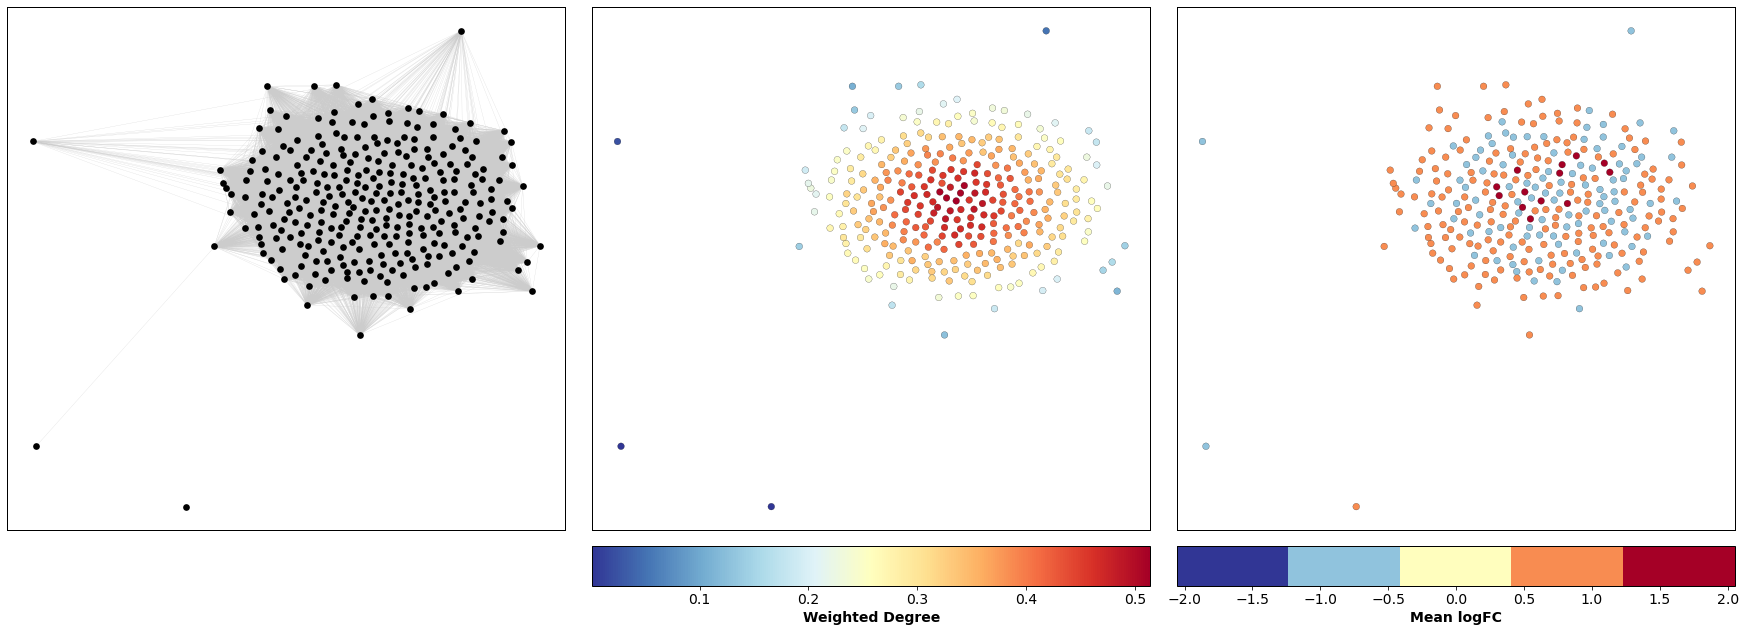

In [25]:
visualize_network_color_by_weighted_deg_and_logFC(S, pos, 'network colored by weighted deg and mean logFC nodes with high logFC')

### [2.2] Run gene-enrichment analysis on genes within subnetwork

#### Load and prepare gene sets

DataFrame for the Gene Sets (excel files from Wen-Han)

In [26]:
GeneSets_df = pd.read_csv(f'{Gene_Set_dir}GeneModule.csv')

#subset to the IMMUNE modules
GeneSets_IMMUNE_df = GeneSets_df.loc[0:258, :] # 'LI' Immune Gene Sets
#GeneSets_IMMUNE_df = GeneSets_df.loc[259:297, :] # 'DC' Immune Gene Sets

#subset to the REACTOME modules
GeneSets_REACTOME_df = GeneSets_df.loc[993:1666, :]

In [27]:
GeneSets_IMMUNE_df.head()

,ID,Title,Category,B
0,LI.M0,targets of FOSL1/2,TF targets,12
1,LI.M1.0,integrin cell surface interactions (I),molecular function,29
2,LI.M1.1,integrin cell surface interactions (II),molecular function,12
3,LI.M2.0,extracellular matrix (I),location,30
4,LI.M2.1,extracellular matrix (II),location,45


In [28]:
np.shape(GeneSets_IMMUNE_df)

(259, 4)

In [29]:
GeneSets_REACTOME_df.head()

,ID,Title,Category,B
993,M19193,Reactome glycogen breakdown glycogenolysis,C2:CP:REACTOME,18
994,M8229,Reactome translation,C2:CP:REACTOME,222
995,M10654,Reactome pyrimidine catabolism,C2:CP:REACTOME,12
996,M486,Reactome rna pol iii transcription initiation ...,C2:CP:REACTOME,23
997,M489,Reactome inhibition of the proteolytic activit...,C2:CP:REACTOME,24


In [30]:
np.shape(GeneSets_REACTOME_df)

(674, 4)

DataFrame for the genes that belong to each Gene Set

In [31]:
GeneSet_GeneLists_df = pd.read_csv(f'{Gene_Set_dir}GeneModule_Genelist.csv')
GeneSet_GeneLists_df.set_index('ID', drop = True, inplace = True)

In [32]:
GeneSet_GeneLists_df.head()

,Gene
ID,
LI.M0,CCL2
LI.M0,DCN
LI.M0,LIF
LI.M0,PLAU
LI.M0,IL6


In [33]:
np.shape(GeneSet_GeneLists_df)

(84042, 1)

#### Convert gene sets to a dictionary 
- keys: gene sets
- values: list of genes belonging to each set

In [34]:
#Immune-specific gene sets
gene_set_IMMUNE_dict = {}
for gene_set_i in GeneSets_IMMUNE_df.ID:
    
    gene_list_for_set_i = list(GeneSet_GeneLists_df[GeneSet_GeneLists_df.index == gene_set_i].Gene)
    gene_set_IMMUNE_dict[gene_set_i] = gene_list_for_set_i

#Reactome gene sets
gene_set_REACTOME_dict = {}
for gene_set_i in GeneSets_REACTOME_df.ID:
    
    gene_list_for_set_i = list(GeneSet_GeneLists_df[GeneSet_GeneLists_df.index == gene_set_i].Gene)
    gene_set_REACTOME_dict[gene_set_i] = gene_list_for_set_i

In [35]:
len(gene_set_IMMUNE_dict.keys()) #number of gene sets

259

In [36]:
len(gene_set_REACTOME_dict.keys()) #number of gene sets

674

### *Function* to run gene set enrichment

In [37]:
def run_enrichr_on_list_of_genes(gene_list, gene_set_category):
    
    #specify which gene sets we'll probe for enrichment
    if gene_set_category == 'IMMUNE':
        gene_set_dict = gene_set_IMMUNE_dict
    elif gene_set_category == 'REACTOME':
        gene_set_dict = gene_set_REACTOME_dict
    
    #run enrichr
    enr = gp.enrichr(gene_list = gene_list,  
        gene_sets = gene_set_dict,
        background = 'hsapiens_gene_ensembl',
        organism = 'Human',
        description = f'community pathway enrichment',
        outdir = f'{Data_files_dir}/enrichr gene set analyses bucket',
        no_plot = True)

    #filter & sort enrichr results df
    enrichr_results_df = enr.results
    enrichr_results_df = enrichr_results_df.loc[: , ['Term', 'P-value', 'Adjusted P-value', 'Overlap', 'Genes']] #subset to necessary columns
    enrichr_results_df.rename(columns = {'Term':'ID'}, inplace = True) #rename column for merging with Gene Set df
    enrichr_results_df = enrichr_results_df[enrichr_results_df.loc[: , 'Adjusted P-value'] <= 0.001] #keep hits with lowest adj. p-vals
    enrichr_results_df.sort_values(by = 'Adjusted P-value', ascending = True , inplace = True) #sort by lowest p-val
    enrichr_results_df.reset_index(inplace = True, drop = True) #reset index
    enrichr_results_df = enrichr_results_df.merge(GeneSets_df.loc[: , ['ID','Title','Category']], how = 'left', on = 'ID') #get details for gene sets
    
    #average the (mean logFC) for each gene detected as part of the gene set and append as another column
    avg_meanlogFC = [mean_logFC_series[enrichr_results_df.Genes[pathway_i].split(';')].mean() for pathway_i in enrichr_results_df.index]
    enrichr_results_df.loc[: , 'logFC'] = avg_meanlogFC
    
    return enrichr_results_df

Run **gene set enrichment** on genes in subnetwork

Pathway enrichment with **Immune** modules

In [38]:
run_enrichr_on_list_of_genes(list(S.nodes), 'IMMUNE')

,ID,P-value,Adjusted P-value,Overlap,Genes,Title,Category,logFC
0,LI.M37.0,1.100335e-45,1.386422e-43,61/347,DEFA1;SH2D1A;S100A8;SMCO4;CLEC5A;LCN2;F5;CD3G;...,immune activation - generic cluster,immune,0.597835
1,LI.M7.0,3.073396e-24,1.936240e-22,22/62,RASGRP1;SH2D1A;GZMK;CD3G;BCL11B;EOMES;CD27;KLR...,enriched in T cells (I),immune,-0.697044
2,LI.M11.0,3.716488e-19,1.560925e-17,28/189,S100A8;MEGF9;CRISPLD2;LILRA6;CD36;FCGR1B;FAM19...,enriched in monocytes (II),immune,0.756518
3,LI.M7.1,1.245235e-18,3.922489e-17,17/50,RASGRP1;ITK;ZAP70;RORA;ICOS;CD3G;LEF1;CD5;BCL1...,T cell activation (I),immune,-0.678255
4,LI.M7.4,2.370187e-11,5.972871e-10,8/15,RASGRP1;RORA;ETS1;LEF1;KLF12;NELL2;CD96;ATP8B2,T cell activation (III),immune,-0.715314
5,LI.S4,3.473837e-09,6.252907e-08,13/94,MCTP1;ASGR1;MARCO;TLR4;CCR2;CLEC12A;DYSF;ASGR2...,Monocyte surface signature,immune,0.824524
6,LI.M165,3.110783e-09,6.252907e-08,9/35,IFI27;RSAD2;PRRG4;SERPING1;CCL20;PARP9;TNFAIP6...,enriched in activated dendritic cells (II),immune,0.687986
7,LI.M7.2,4.684985e-09,7.378851e-08,10/49,TGFBR3;ZAP70;ITK;KLRB1;RORA;PLEKHF1;CD247;PRKC...,enriched in NK cells (I),immune,-0.633413
8,LI.M4.0,5.641234e-09,7.897728e-08,23/335,LILRA6;LMNB1;CD36;FCGR1B;FAM198B;CLEC4E;PGLYRP...,cell cycle and transcription,biological process,0.798650
9,LI.M5.0,6.291460e-09,7.927239e-08,12/81,ITK;ZAP70;TLR4;CD3G;TLR5;MAPK14;CD247;LY96;IRA...,regulation of antigen presentation and immune ...,immune,0.113542


Pathway enrichment with **Reactome** modules

In [39]:
run_enrichr_on_list_of_genes(list(S.nodes), 'REACTOME')

,ID,P-value,Adjusted P-value,Overlap,Genes,Title,Category,logFC
0,M1045,3.681647e-17,1.016135e-14,55/933,RASGRP1;DEFA1;CASP1;C1QB;OAS1;CD3G;DEFA4;DEFA1...,Reactome immune system,C2:CP:REACTOME,0.555216
1,M1036,1.608124e-10,2.219210e-08,23/279,DEFA1;CASP1;C1QB;DEFA4;DEFA1B;C2;DEFA3;C1QA;DU...,Reactome innate immune system,C2:CP:REACTOME,0.828892
2,M983,8.043078e-10,7.399632e-08,17/159,IFI27;GBP1;IFIT3;OAS1;JAK2;FCGR1B;GBP4;ISG15;F...,Reactome interferon signaling,C2:CP:REACTOME,0.942395
3,M1060,2.944483e-09,2.031694e-07,21/270,CASP1;OAS1;FCGR1B;GBP5;GBP6;JAK2;UBE2L6;IFITM3...,Reactome cytokine signaling in immune system,C2:CP:REACTOME,0.800241
4,M965,4.521906e-09,2.496092e-07,11/63,GBP1;OAS1;OASL;JAK2;GBP4;FCGR1A;GBP5;OAS3;FCGR...,Reactome interferon gamma signaling,C2:CP:REACTOME,1.048059
5,M973,8.064776e-07,3.709797e-05,9/64,IFI27;OAS1;ISG15;OAS3;IFITM3;IFI35;OASL;SOCS3;...,Reactome interferon alpha beta signaling,C2:CP:REACTOME,0.708423
6,M19752,1.045278e-05,4.121382e-04,6/32,C5;C1QB;C1QC;C2;C1QA;CR1,Reactome complement cascade,C2:CP:REACTOME,0.906982


## [3] Calculate *num edges*, *mean edge weight*, *num nodes* & *mean weighted degree*  for subgraphs induced by highest weighted edges

#### Edges Weights for Node Pairs (gene pairs)

In [40]:
edge_weight_dict = nx.get_edge_attributes(G, 'weight') #keys: node pairs; values: edge weights
edge_weight_array = np.array(list(edge_weight_dict.values())) #array of edge weights in graph

In [41]:
len(edge_weight_array)

683108

In [42]:
edge_weight_array.mean()

0.2237516798222243

#### Distribution of Edge Weights in original Network

In [43]:
def prettify_plot(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(False)
    ax.tick_params(labelcolor = 'k')
    ax.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
    ax.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')

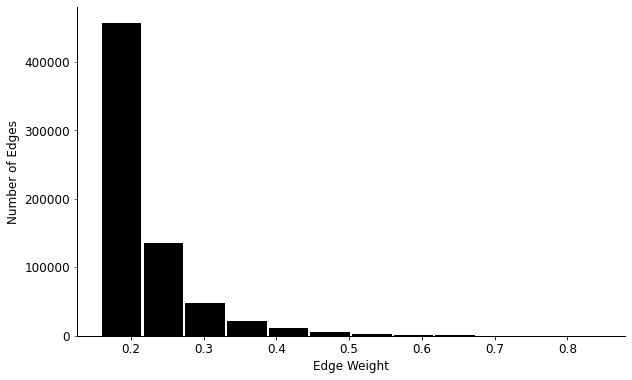

In [44]:
fig = plt.figure(constrained_layout=True)

gs = GridSpec(1, 1, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])

#EDGE WEIGHTS
ax1.hist(edge_weight_array , bins = len(set(edge_weight_array)), color = 'black' , rwidth = 0.95 , edgecolor='white', linewidth=0.0, align='left')

ax1.set_ylabel('Number of Edges', fontsize = 12, color = 'k')
ax1.set_xlabel('Edge Weight' , fontsize = 12, color = 'k')

prettify_plot(ax1)
#ax1.set_yscale('log')
    
################### Plot ###################
fig = plt.gcf()
fig.set_size_inches(9, 5.5)
fig.tight_layout()

file_name = f'{figures_dir_path}/{comparison_X} distribution of edge weights in entire network.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

In [45]:
edge_weight_thresholds = np.sort(np.array(list(set(edge_weight_array))))
edge_weight_thresholds

array([0.1875, 0.25  , 0.3125, 0.375 , 0.4375, 0.5   , 0.5625, 0.625 ,
       0.6875, 0.75  , 0.8125, 0.875 ])

### *Function* that returns attributes of a subgraph induced by setting a threshold on edge weights

In [46]:
def get_characteristics_of_subgraph(edge_weight_thresh):
    
    '''
    (1) This function returns the mean (edge weight) & (weighted degree) of the subgraph induced by the edges 
    that pass the edge weight threshold in the larger network.
    
    (2) Function returns the (# Edges) and (# Nodes) for these different subgraphs.
    '''
    
    #get the EDGE WEIGHTS for edges in the network that pass the edge weight threshold
    edge_weight_dict_subset = {key:value for key, value in edge_weight_dict.items() if value >= edge_weight_thresh}
    edge_weight_array_subset = np.array(list(edge_weight_dict_subset.values()))

    #get the SUBGRAPH induced by the most heavily weighted edges
    S = G.edge_subgraph(list(edge_weight_dict_subset.keys()))

    #Get a series of the WEIGHTED DEGREE for each node in the subgraph 
    node_list = [node_deg[0] for node_deg in list(S.degree(weight = 'weight'))]
    degree_list = [node_deg[1] for node_deg in list(S.degree(weight = 'weight'))]
    subgraph_weighted_degree_series = pd.Series(degree_list , index = node_list).sort_values(ascending = False)
    
    return [float(len(edge_weight_array_subset)), edge_weight_array_subset.mean(), float(len(node_list)), subgraph_weighted_degree_series.mean()]

#### Iterate through subnetworks of various sizes for different *edge weight thresholds* in original network

In [47]:
num_edges_for_subnetworks_list = []
mean_edge_weight_for_subnetworks_list = []
num_nodes_for_subnetworks_list = []
mean_weighted_deg_for_subnetworks_list = []

for edge_weight_thresh in edge_weight_thresholds:
    
    subgraph_num_edges , subgraph_mean_edge_weight , subgraph_num_nodes , subgraph_mean_weighted_deg = get_characteristics_of_subgraph(edge_weight_thresh)
    
    num_edges_for_subnetworks_list.append(subgraph_num_edges)
    mean_edge_weight_for_subnetworks_list.append(subgraph_mean_edge_weight)
    num_nodes_for_subnetworks_list.append(subgraph_num_nodes)
    mean_weighted_deg_for_subnetworks_list.append(subgraph_mean_weighted_deg)
    
    print(edge_weight_thresh)
    
#convert to arrays
num_edges_for_subnetworks = np.array(num_edges_for_subnetworks_list)
mean_edge_weight_for_subnetworks = np.array(mean_edge_weight_for_subnetworks_list)
num_nodes_for_subnetworks = np.array(num_nodes_for_subnetworks_list)
mean_weighted_deg_for_subnetworks = np.array(mean_weighted_deg_for_subnetworks_list)

0.1875
0.25
0.3125
0.375
0.4375
0.5
0.5625
0.625
0.6875
0.75
0.8125
0.875


#### Plot various characteristics of subgraphs induced by highest weighted edges

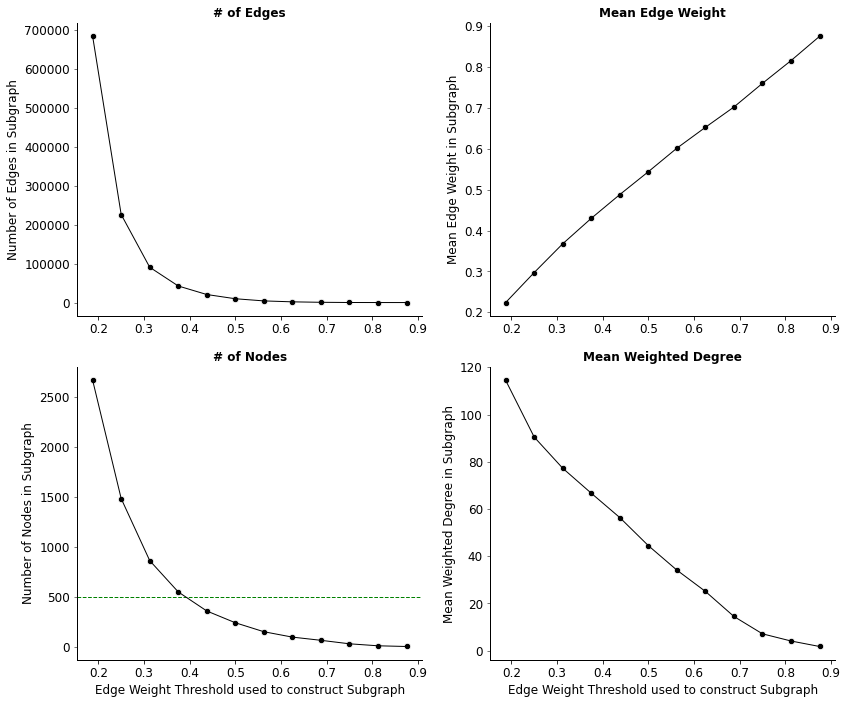

In [48]:
fig = plt.figure(constrained_layout=True)

gs = GridSpec(2, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

#NUMBER OF EDGES
ax1.scatter(edge_weight_thresholds, num_edges_for_subnetworks , color = 'black' , linewidth=0.75 , edgecolor = 'white' , s = 40 , alpha = 1.0)
ax1.plot(edge_weight_thresholds, num_edges_for_subnetworks , color = 'black' , linewidth=1.0)

ax1.set_ylabel('Number of Edges in Subgraph', fontsize = 12, color = 'k')
ax1.set_title('# of Edges', fontsize = 12, color = 'k' , weight = 'bold')

prettify_plot(ax1)

#EDGE WEIGHT
ax2.scatter(edge_weight_thresholds, mean_edge_weight_for_subnetworks , color = 'black' , linewidth=0.75 , edgecolor = 'white' , s = 40 , alpha = 1.0)
ax2.plot(edge_weight_thresholds, mean_edge_weight_for_subnetworks , color = 'black' , linewidth=1.0)

ax2.set_ylabel('Mean Edge Weight in Subgraph', fontsize = 12, color = 'k')
ax2.set_title('Mean Edge Weight', fontsize = 12, color = 'k' , weight = 'bold')

prettify_plot(ax2)

#NUMBER OF NODES

#targeting sub-networks with around ~50-500 nodes
ax3.axhline(y = 500, linewidth = 1.0, color = 'green', linestyle = '--')
#ax3.axhline(y = 50, linewidth = 1.0, color = 'green', linestyle = '--')

ax3.scatter(edge_weight_thresholds, num_nodes_for_subnetworks , color = 'black' , linewidth=0.75 , edgecolor = 'white' , s = 40 , alpha = 1.0)
ax3.plot(edge_weight_thresholds, num_nodes_for_subnetworks , color = 'black' , linewidth=1.0)

ax3.set_ylabel('Number of Nodes in Subgraph', fontsize = 12, color = 'k')
ax3.set_xlabel('Edge Weight Threshold used to construct Subgraph' , fontsize = 12, color = 'k')
ax3.set_title('# of Nodes', fontsize = 12, color = 'k' , weight = 'bold')

prettify_plot(ax3)
    
#WEIGHTED DEGREE
ax4.scatter(edge_weight_thresholds, mean_weighted_deg_for_subnetworks , color = 'black' , linewidth=0.75 , edgecolor = 'white' , s = 40 , alpha = 1.0)
ax4.plot(edge_weight_thresholds, mean_weighted_deg_for_subnetworks , color = 'black' , linewidth=1.0)

ax4.set_ylabel('Mean Weighted Degree in Subgraph', fontsize = 12, color = 'k')
ax4.set_xlabel('Edge Weight Threshold used to construct Subgraph' , fontsize = 12, color = 'k')
ax4.set_title('Mean Weighted Degree', fontsize = 12, color = 'k' , weight = 'bold')

prettify_plot(ax4)
    
################### Plot ###################
fig = plt.gcf()
fig.set_size_inches(12, 10)
fig.tight_layout()

file_name = f'{figures_dir_path}/{comparison_X} characteristics of subgraphs from increasing edge weight threshold.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

How does the **edge weight threshold** affect the **number of nodes** in the subnetwork?

In [49]:
for edge_weight_thresh_i, num_nodes_subnetwork_i in zip(edge_weight_thresholds, num_nodes_for_subnetworks):
    print(f'Edge Weight Threshold = {edge_weight_thresh_i} , Number of Nodes in Subnetwork = {num_nodes_subnetwork_i}')

Edge Weight Threshold = 0.1875 , Number of Nodes in Subnetwork = 2670.0
Edge Weight Threshold = 0.25 , Number of Nodes in Subnetwork = 1484.0
Edge Weight Threshold = 0.3125 , Number of Nodes in Subnetwork = 862.0
Edge Weight Threshold = 0.375 , Number of Nodes in Subnetwork = 548.0
Edge Weight Threshold = 0.4375 , Number of Nodes in Subnetwork = 357.0
Edge Weight Threshold = 0.5 , Number of Nodes in Subnetwork = 239.0
Edge Weight Threshold = 0.5625 , Number of Nodes in Subnetwork = 149.0
Edge Weight Threshold = 0.625 , Number of Nodes in Subnetwork = 95.0
Edge Weight Threshold = 0.6875 , Number of Nodes in Subnetwork = 63.0
Edge Weight Threshold = 0.75 , Number of Nodes in Subnetwork = 28.0
Edge Weight Threshold = 0.8125 , Number of Nodes in Subnetwork = 8.0
Edge Weight Threshold = 0.875 , Number of Nodes in Subnetwork = 1.0


We're aiming to run enrichment analysis on **~50-500 nodes** so we have to adjust the edge-weight thresholds for this.

In [50]:
print(edge_weight_thresholds[3:-3])

[0.375  0.4375 0.5    0.5625 0.625  0.6875]


In [51]:
edge_weight_thresholds = edge_weight_thresholds[3:-3]

## [4] Iterate through subnetworks constructed from most heavily weighted edges and preform gene enrichment analysis

### *Function* to plot subnetworks (after thresholding edge weights) & perform gene enrichment on nodes

In [52]:
def subgraph_visualize_and_gene_enrichment(edge_weight_thresh, gene_set_category):
    
    '''
    (1) This function returns visualizes the sub-network generated by 
    retaining only the edge weights above the input edge weight threshold.
        (1.1) colors nodes by weighted degree
        (1.2) colors nodes by mean logFC
        
    (2) This function also returns a dataframe from the gene enrichment 
    analysis run on the nodes of the subnetwork.
    '''
    
    #get the EDGE WEIGHTS for edges in the network that pass the edge weight threshold
    edge_weight_dict_subset = {key:value for key, value in edge_weight_dict.items() if value >= edge_weight_thresh}
    edge_weight_array_subset = np.array(list(edge_weight_dict_subset.values()))

    #get the SUBGRAPH induced by the most heavily weighted edges
    S = G.edge_subgraph(list(edge_weight_dict_subset.keys()))
    
    #print some stats
    print('')
    print('')
    print('')
    print('')
    print(f'Edge Weight Threshold = {edge_weight_thresh}')
    print(f'Number of Nodes = {len(S.nodes)}')
    print('---------------------------------------------')
    
    #visualize subgraph
    pos = nx.spring_layout(S , weight = 'weight' , iterations = 350 , k = 3.0)
    visualize_network_color_by_weighted_deg_and_logFC(S, pos)
    
    #gene set enrichment
    gene_enrichr_df = run_enrichr_on_list_of_genes(list(S.nodes), gene_set_category)
    print(f'gene enrichment for nodes in this network: ')
    display(gene_enrichr_df.head(n=40)) #return the top 40 hits if there are > 40
    print('---------------------------------------------')
    
    ## return gene_enrichr_df #uncomment to return dataframe

#### Iterate through subnetworks of various sizes for different *edge weight thresholds* in original network

We're going to start with the largest **edge weight threshold** and iterate up from there (decrease edge weight threshold but decrease # of nodes) to preform gene enrichment

### [4.1] Using *Immune* Gene Sets for gene enrichment





Edge Weight Threshold = 0.6875
Number of Nodes = 63
---------------------------------------------


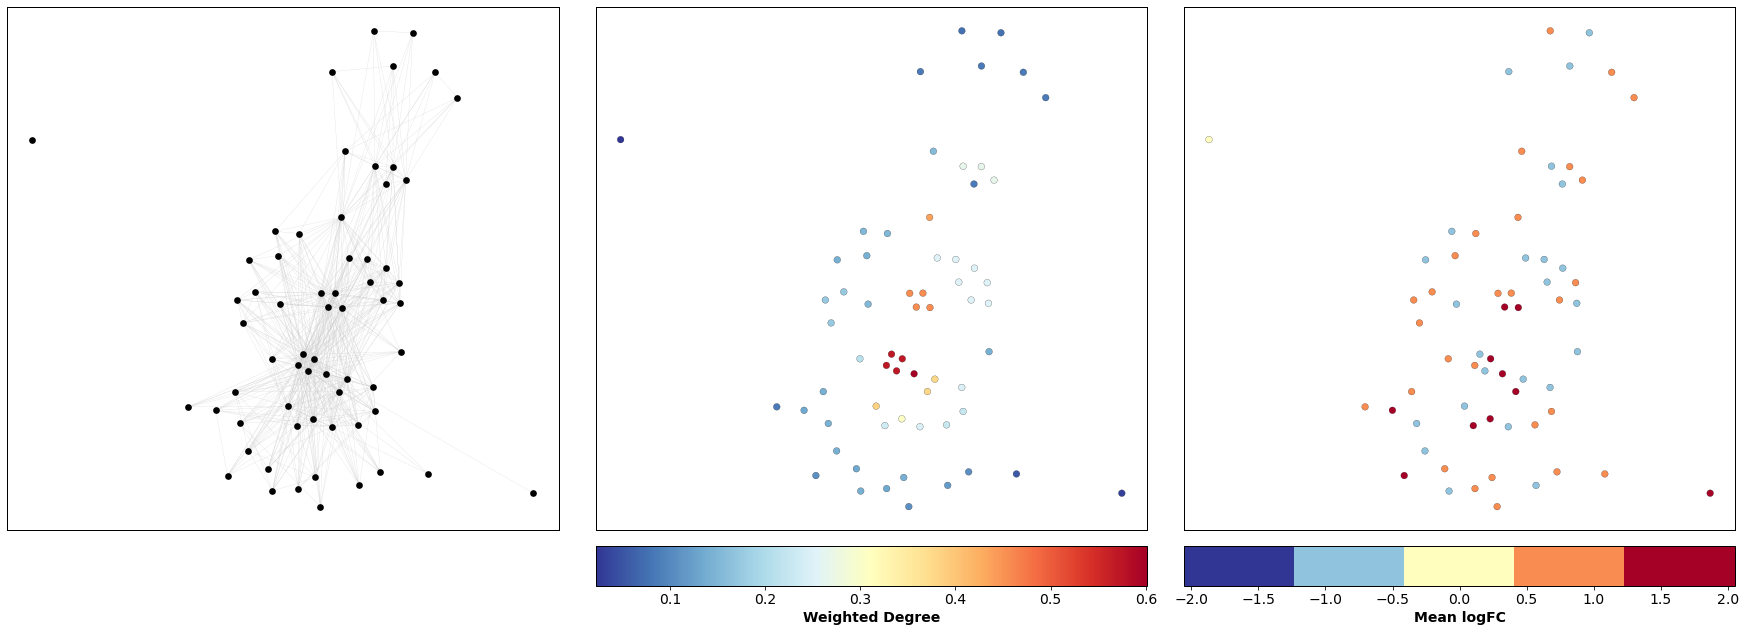

gene enrichment for nodes in this network: 


,ID,P-value,Adjusted P-value,Overlap,Genes,Title,Category,logFC
0,LI.M7.0,9.241869e-17,6.192052e-15,11/62,GZMK;ITK;ETS1;KLRB1;LEF1;BCL11B;CD6;CD247;CD96...,enriched in T cells (I),immune,-0.735851
1,LI.M7.1,2.750263e-10,9.213381e-09,7/50,ITK;LEF1;BCL11B;CD247;CCR7;IL7R;CD27,T cell activation (I),immune,-0.784180
2,LI.M18,3.528252e-08,7.879764e-07,4/11,SPOCK2;ABLIM1;ITK;ETS1,T cell differentiation via ITK and PKC,immune,-0.734770
3,LI.M117,6.242178e-07,1.045565e-05,4/21,SPOCK2;LEF1;CD6;CD96,cell adhesion (GO),molecular function,-0.743827
4,LI.M14,7.434272e-06,9.961924e-05,3/12,SPOCK2;ITK;BCL11B,T cell differentiation,immune,-0.740385
5,LI.M109,1.526678e-05,1.190911e-04,3/15,CCR7;LEF1;S1PR1,"receptors, cell migration",molecular function,-0.934751
6,LI.M16,1.599731e-05,1.190911e-04,4/46,FCGR1A;FCGR1B;DYSF;KCNJ15,TLR and inflammatory signaling,immune,1.421928
7,LI.M7.4,1.526678e-05,1.190911e-04,3/15,LEF1;CD96;ETS1,T cell activation (III),immune,-0.740239
8,LI.M65,1.224233e-05,1.190911e-04,3/14,CCR7;IL7R;ITK,"IL2, IL7, TCR network",immune,-0.860278
9,LI.M7.2,2.061687e-05,1.255755e-04,4/49,CD247;ITK;CD96;KLRB1,enriched in NK cells (I),immune,-0.669666


---------------------------------------------




Edge Weight Threshold = 0.625
Number of Nodes = 95
---------------------------------------------


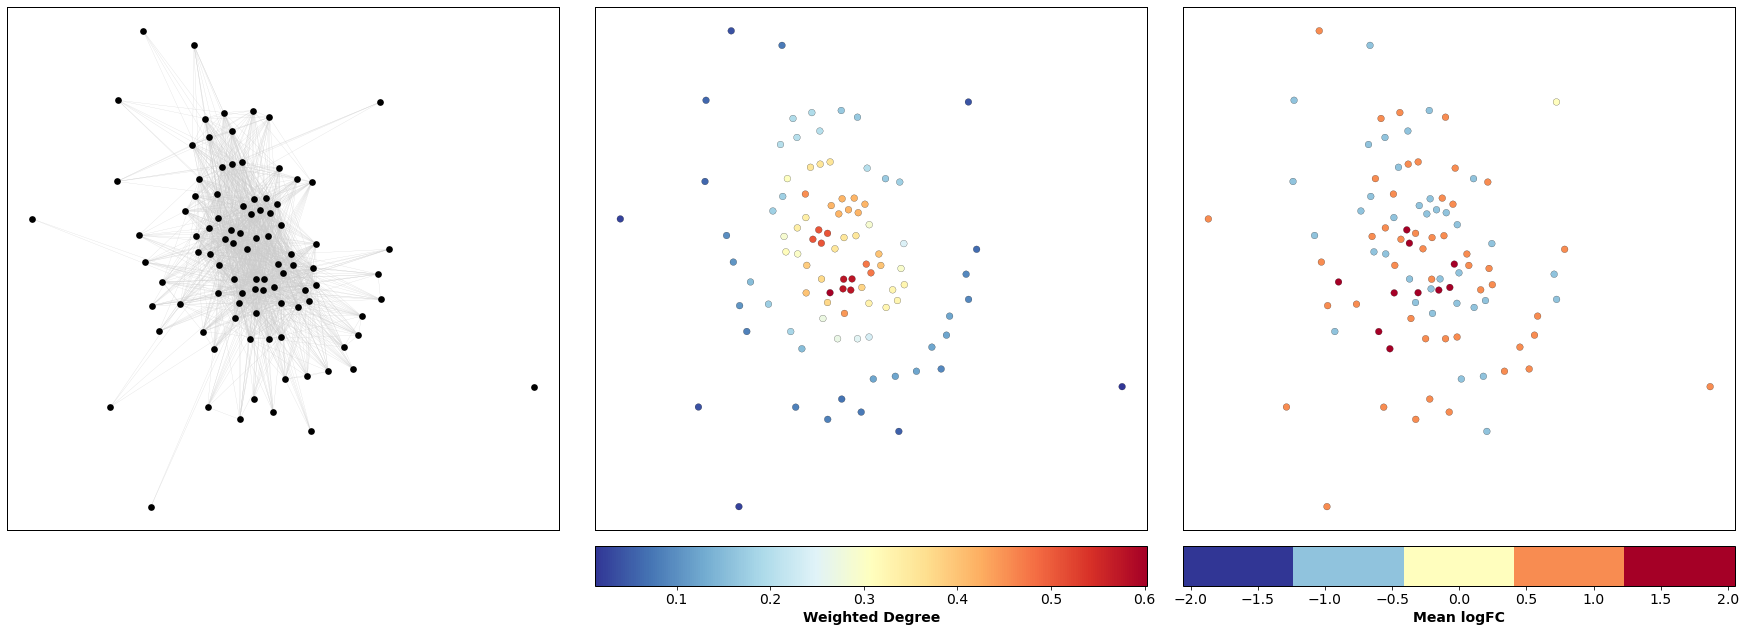

gene enrichment for nodes in this network: 


,ID,P-value,Adjusted P-value,Overlap,Genes,Title,Category,logFC
0,LI.M7.0,5.221932e-20,4.073107e-18,14/62,GZMK;SH2D1A;ITK;KLRB1;ETS1;LEF1;BCL11B;CD6;PRK...,enriched in T cells (I),immune,-0.744451
1,LI.M37.0,1.289879e-12,5.030529e-11,17/347,KCNJ15;SH2D1A;MCTP1;CAMP;MMP9;SMCO4;LCN2;DYSF;...,immune activation - generic cluster,immune,0.733158
2,LI.M7.1,2.752476e-12,7.156438e-11,9/50,ITK;LEF1;BCL11B;ITPR3;CD247;PRKCH;CCR7;IL7R;CD27,T cell activation (I),immune,-0.745783
3,LI.M18,5.950212e-12,1.160291e-10,6/11,SH2D1A;ITK;ETS1;SPOCK2;ABLIM1;PRKCH,T cell differentiation via ITK and PKC,immune,-0.705694
4,LI.M11.0,2.603533e-09,4.061511e-08,11/189,ASGR1;MYOF;ASGR2;FCGR1B;TLR5;CRISPLD2;FCGR1A;H...,enriched in monocytes (II),immune,1.021013
5,LI.M117,5.309686e-08,6.902592e-07,5/21,SPOCK2;LEF1;NELL2;CD96;CD6,cell adhesion (GO),molecular function,-0.801634
6,LI.M14,2.791251e-07,3.110251e-06,4/12,SPOCK2;SH2D1A;ITK;BCL11B,T cell differentiation,immune,-0.736719
7,LI.S4,4.421201e-07,4.310671e-06,7/94,MCTP1;ASGR1;DYSF;ASGR2;TLR5;CD36;FCGR1B,Monocyte surface signature,immune,1.027877
8,LI.M7.4,7.609211e-07,6.594649e-06,4/15,LEF1;NELL2;CD96;ETS1,T cell activation (III),immune,-0.813395
9,LI.M16,3.241213e-06,2.528146e-05,5/46,KCNJ15;DYSF;TLR5;FCGR1A;FCGR1B,TLR and inflammatory signaling,immune,1.341213


---------------------------------------------




Edge Weight Threshold = 0.5625
Number of Nodes = 149
---------------------------------------------


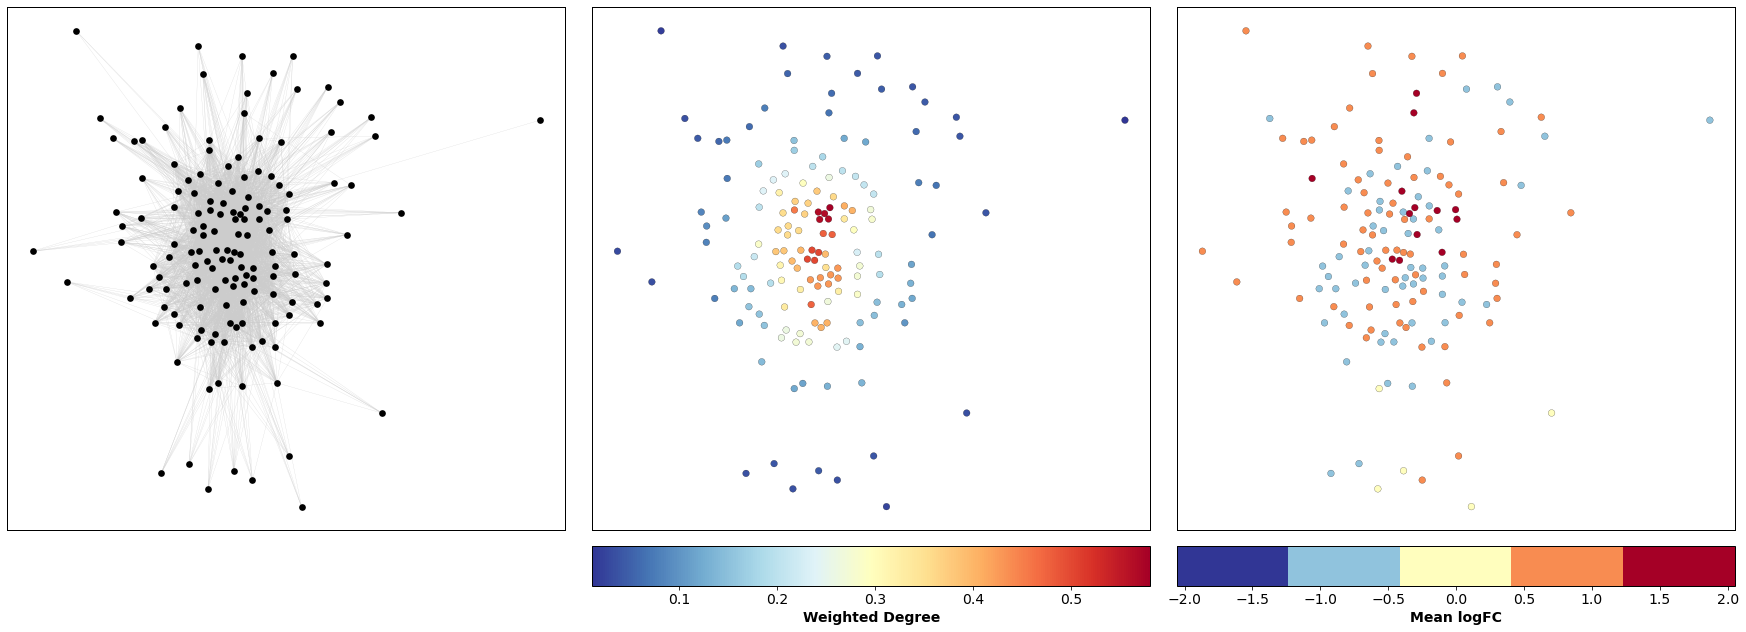

gene enrichment for nodes in this network: 


,ID,P-value,Adjusted P-value,Overlap,Genes,Title,Category,logFC
0,LI.M7.0,9.328978e-26,8.675949e-24,19/62,GZMK;SH2D1A;ITK;ZAP70;KLRB1;ETS1;ICOS;LEF1;BCL...,enriched in T cells (I),immune,-0.694860
1,LI.M37.0,1.006675e-21,4.681037e-20,29/347,SH2D1A;SMCO4;LCN2;DEFA4;BCL11B;CRISPLD2;CA4;LR...,immune activation - generic cluster,immune,0.729523
2,LI.M7.1,6.703090e-17,2.077958e-15,13/50,ITK;ZAP70;ICOS;LEF1;BCL11B;CD2;ITPR3;CD247;PRK...,T cell activation (I),immune,-0.708645
3,LI.M18,9.282584e-11,2.158201e-09,6/11,SH2D1A;ITK;ETS1;SPOCK2;ABLIM1;PRKCH,T cell differentiation via ITK and PKC,immune,-0.705694
4,LI.M11.0,2.801694e-10,5.211151e-09,14/189,ASGR1;MYOF;ASGR2;FCGR1B;TLR5;CRISPLD2;FCGR1A;H...,enriched in monocytes (II),immune,0.960682
5,LI.M7.2,4.001241e-09,6.201924e-08,8/49,TGFBR3;ZAP70;ITK;KLRB1;CD247;PRKCH;CD96;EOMES,enriched in NK cells (I),immune,-0.645267
6,LI.M117,1.022132e-08,1.357975e-07,6/21,ZAP70;SPOCK2;LEF1;NELL2;CD96;CD6,cell adhesion (GO),molecular function,-0.794143
7,LI.M14,2.078614e-08,2.416389e-07,5/12,SH2D1A;ITK;LRRN3;SPOCK2;BCL11B,T cell differentiation,immune,-0.782945
8,LI.M109,7.733461e-08,7.192119e-07,5/15,LRRK2;TGFBR3;S1PR1;LEF1;CCR7,"receptors, cell migration",molecular function,-0.524135
9,LI.M7.4,7.733461e-08,7.192119e-07,5/15,ETS1;LEF1;NELL2;CD96;ATP8B2,T cell activation (III),immune,-0.766552


---------------------------------------------




Edge Weight Threshold = 0.5
Number of Nodes = 239
---------------------------------------------


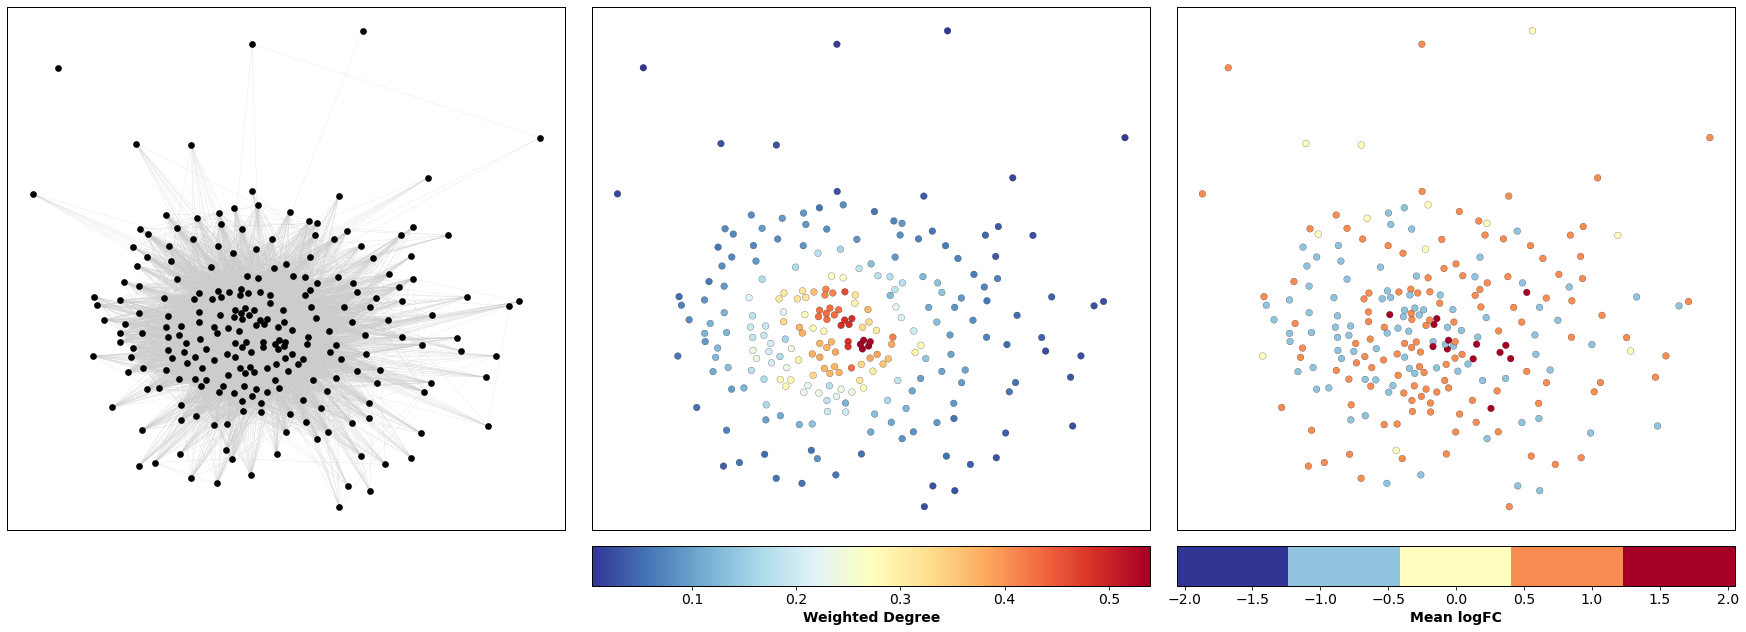

gene enrichment for nodes in this network: 


,ID,P-value,Adjusted P-value,Overlap,Genes,Title,Category,logFC
0,LI.M7.0,2.767099e-37,3.043808e-35,28/62,RASGRP1;SH2D1A;GZMK;PRKCQ;ITM2A;CD3G;BCL11B;CD...,enriched in T cells (I),immune,-0.636465
1,LI.M37.0,2.776968e-30,1.527332e-28,43/347,SH2D1A;DEFA1;SMCO4;LCN2;CD3G;DEFA4;BCL11B;CRIS...,immune activation - generic cluster,immune,0.645872
2,LI.M7.1,1.422442e-25,5.215621e-24,20/50,CD3D;RASGRP1;SLAMF1;ITK;ZAP70;RORA;ICOS;IL7R;C...,T cell activation (I),immune,-0.636438
3,LI.M11.0,1.356368e-18,3.730011e-17,25/189,CRISPLD2;CD36;LILRA5;FCGR1B;FAM198B;GRN;QPCT;R...,enriched in monocytes (II),immune,0.767918
4,LI.M7.2,7.519638e-16,1.654320e-14,14/49,TGFBR3;ZAP70;ITK;KLRB1;RORA;GNLY;IL2RB;PLEKHF1...,enriched in NK cells (I),immune,-0.581207
5,LI.M7.4,3.118173e-14,5.716651e-13,9/15,RASGRP1;RORA;ETS1;LEF1;KLF12;NELL2;CD96;PRKCQ;...,T cell activation (III),immune,-0.685288
6,LI.M18,8.754604e-14,1.375723e-12,8/11,SH2D1A;ITK;ITM2A;ETS1;SPOCK2;ABLIM1;PRKCH;PRKCQ,T cell differentiation via ITK and PKC,immune,-0.636768
7,LI.M117,9.687689e-11,1.332057e-09,8/21,ZAP70;PRKCQ;SPOCK2;LEF1;NELL2;LY9;CD96;CD6,cell adhesion (GO),molecular function,-0.711869
8,LI.M5.1,7.045522e-10,8.611194e-09,8/26,ITK;ZAP70;CD3G;CD2;CD247;CD52;CCR7;CD3D,T cell activation and signaling,immune,-0.594397
9,LI.S0,9.904222e-10,1.089464e-08,8/27,ITM2A;ICOS;LRRN3;CD3G;SLC38A1;CD2;PTPRCAP;CD6,T cell surface signature,immune,-0.633340


---------------------------------------------




Edge Weight Threshold = 0.4375
Number of Nodes = 357
---------------------------------------------


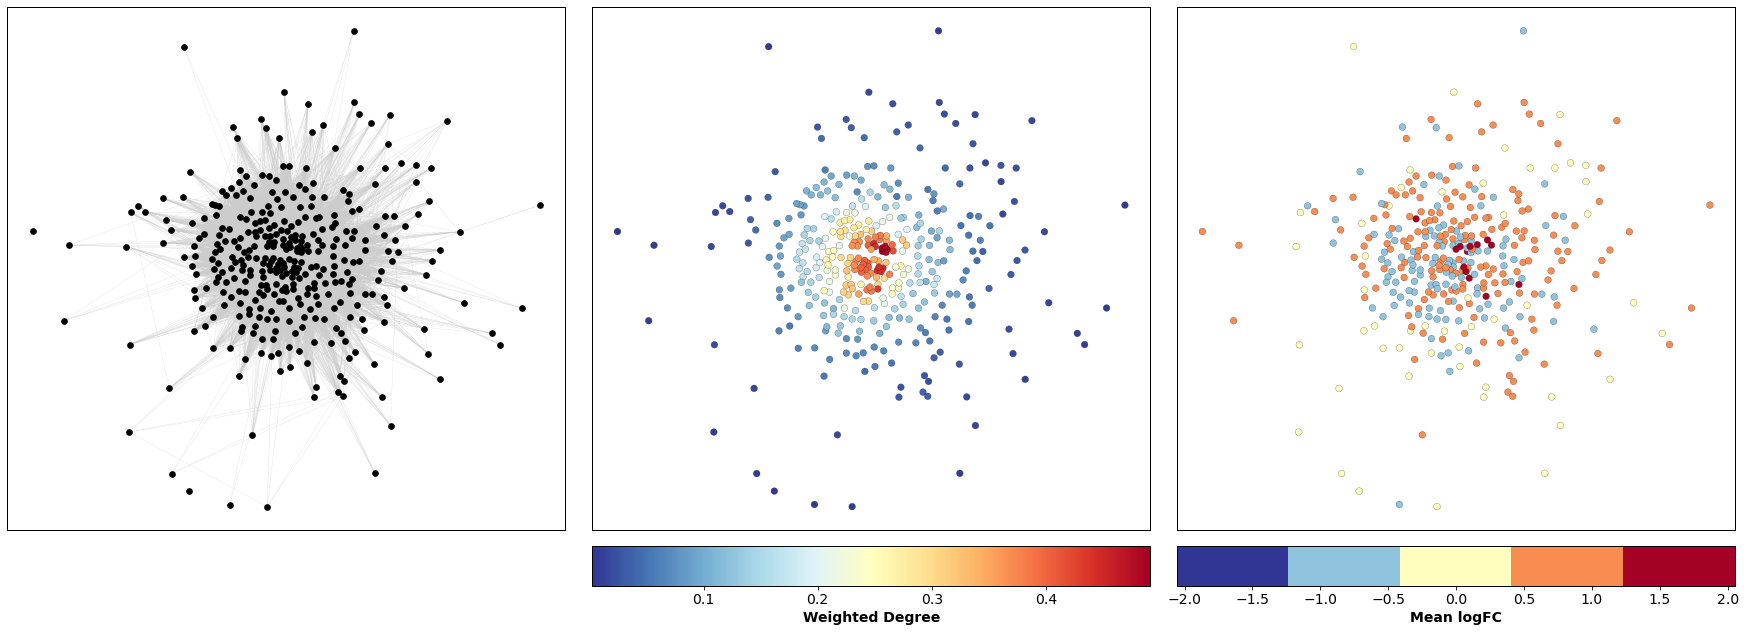

gene enrichment for nodes in this network: 


,ID,P-value,Adjusted P-value,Overlap,Genes,Title,Category,logFC
0,LI.M37.0,1.636506e-41,2.045633e-39,61/347,SH2D1A;DEFA1;S100A8;AQP9;SMCO4;PYGL;CLEC5A;DEF...,immune activation - generic cluster,immune,0.527687
1,LI.M7.0,3.637493e-39,2.273433e-37,32/62,RASGRP1;SH2D1A;GZMK;PRKCQ;ITM2A;CD3G;BCL11B;UB...,enriched in T cells (I),immune,-0.608208
2,LI.M7.1,2.374757e-30,9.894819e-29,25/50,RASGRP1;CD3G;BCL11B;CD3D;EOMES;CD27;CD2;CD247;...,T cell activation (I),immune,-0.595709
3,LI.M11.0,8.099006e-25,2.530940e-23,35/189,AQP9;S100A8;PYGL;HSPA6;CYP1B1;CRISPLD2;CD36;CA...,enriched in monocytes (II),immune,0.650456
4,LI.M7.4,6.793675e-19,1.698419e-17,12/15,RASGRP1;RORA;ETS1;LEF1;ZMYND11;KLF12;NELL2;CD9...,T cell activation (III),immune,-0.615132
5,LI.M7.2,3.186141e-16,6.637794e-15,16/49,TGFBR3;ZAP70;ITK;KLRB1;RORA;GNLY;STAT4;IL2RB;I...,enriched in NK cells (I),immune,-0.508088
6,LI.M5.0,1.292201e-13,2.307502e-12,17/81,CD3D;FCER1G;LCK;ITK;TLR2;ZAP70;CD3G;CD3E;TLR5;...,regulation of antigen presentation and immune ...,immune,-0.047959
7,LI.M7.3,1.608702e-13,2.513597e-12,12/31,SLAMF1;ITK;ZAP70;ICOS;CD3G;CD3E;STAT4;CXCR3;PT...,T cell activation (II),immune,-0.533802
8,LI.M117,1.390556e-12,1.931328e-11,10/21,ZAP70;PRKCQ;SPOCK2;LEF1;CXCR3;NELL2;LY9;CD96;C...,cell adhesion (GO),molecular function,-0.670606
9,LI.M18,2.219420e-12,2.774275e-11,8/11,SH2D1A;ITK;ITM2A;ETS1;SPOCK2;ABLIM1;PRKCH;PRKCQ,T cell differentiation via ITK and PKC,immune,-0.636768


---------------------------------------------




Edge Weight Threshold = 0.375
Number of Nodes = 548
---------------------------------------------


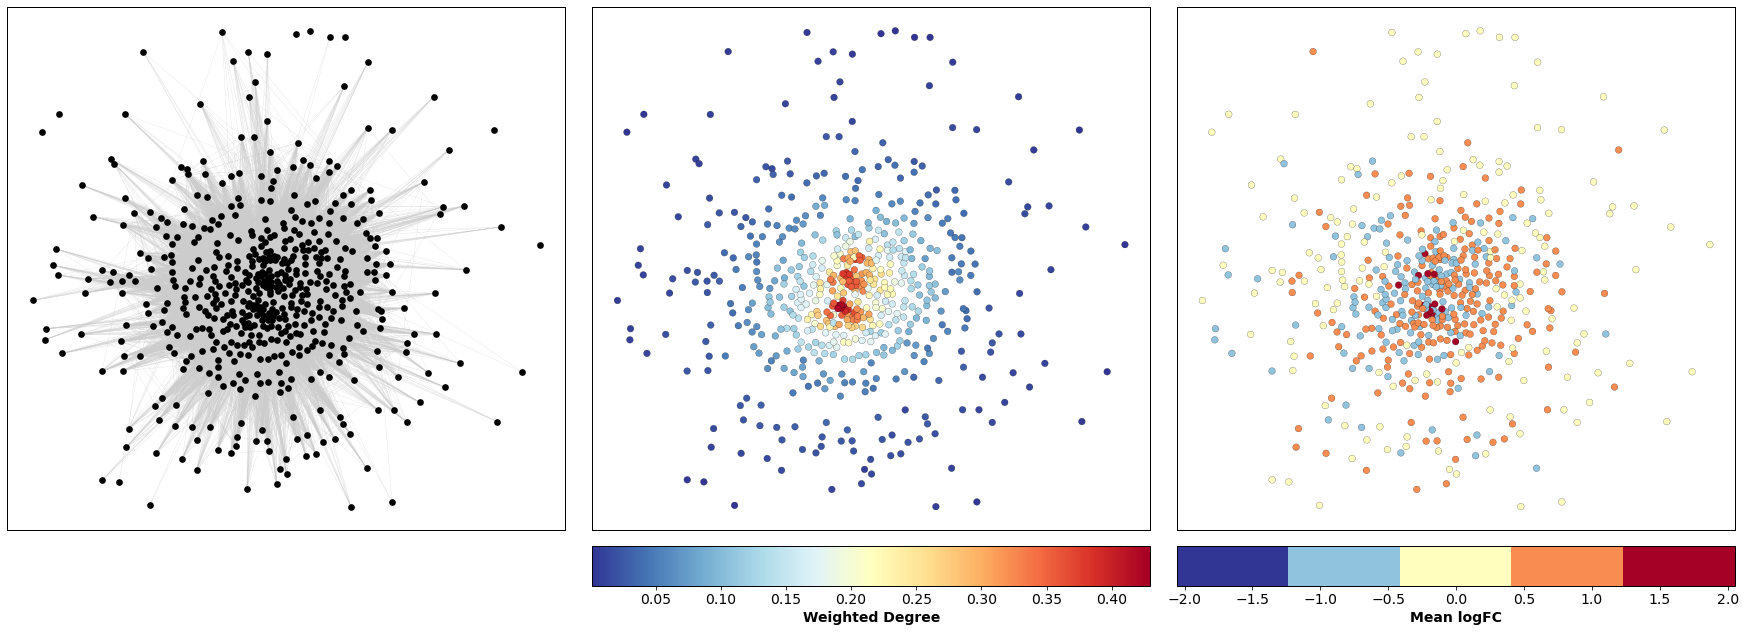

gene enrichment for nodes in this network: 


,ID,P-value,Adjusted P-value,Overlap,Genes,Title,Category,logFC
0,LI.M37.0,1.303928e-52,1.929813e-50,83/347,SH2D1A;DEFA1;S100A8;AQP9;SMCO4;PYGL;CLEC5A;DEF...,immune activation - generic cluster,immune,0.442557
1,LI.M7.0,1.129584e-39,8.358925e-38,36/62,RASGRP1;SH2D1A;GZMK;PRKCQ;ITM2A;CD3G;BCL11B;UB...,enriched in T cells (I),immune,-0.583780
2,LI.M7.1,3.798855e-32,1.874102e-30,29/50,RASGRP1;CD3G;BCL11B;THEMIS;CD3D;EOMES;CD27;CD2...,T cell activation (I),immune,-0.560203
3,LI.M11.0,1.473634e-27,5.452445e-26,44/189,AQP9;S100A8;PYGL;HSPA6;TIMP2;TLR8;LMO2;CRISPLD...,enriched in monocytes (II),immune,0.607733
4,LI.M7.4,8.051571e-19,2.383265e-17,13/15,RASGRP1;RORA;ETS1;LEF1;ZMYND11;KLF12;NELL2;CD9...,T cell activation (III),immune,-0.589158
5,LI.M5.0,3.173815e-18,7.828743e-17,24/81,CD3G;UBASH3A;THEMIS;PLCG1;CD3D;FCGR1B;LIME1;CD...,regulation of antigen presentation and immune ...,immune,-0.068810
6,LI.M7.2,1.382207e-14,2.922380e-13,17/49,TGFBR3;ZAP70;ITK;KLRB1;RORA;GNLY;STAT4;IL2RB;K...,enriched in NK cells (I),immune,-0.498587
7,LI.M7.3,3.839892e-14,7.103800e-13,14/31,SLAMF1;LCK;ITK;ZAP70;ICOS;IL18R1;CD3G;CD3E;STA...,T cell activation (II),immune,-0.446290
8,LI.M4.0,1.172458e-13,1.928042e-12,39/335,HSPA6;TIMP2;TLR8;LMO2;CYP1B1;LILRA6;LMNB1;CD36...,cell cycle and transcription,biological process,0.614675
9,LI.M75,1.426366e-13,2.111021e-12,12/22,IFIH1;C1QB;OAS1;DDX60;SERPING1;HERC5;FCER1A;IR...,antiviral IFN signature,immune,0.751009


---------------------------------------------


In [53]:
for edge_weight_thresh in reversed(edge_weight_thresholds):
    
    subgraph_visualize_and_gene_enrichment(edge_weight_thresh, 'IMMUNE')

## [5] Construct subnetwork from thresholding weighted edges that yields ~500 nodes; preform gene enrichment analysis & color pathways in network

Pick the edge weight threshold that yields ~500 nodes in the subgraph

In [54]:
edge_weight_thresh = 0.375

Visualize sub-network induced by setting edge weight cut-off above

Number of Nodes = 548


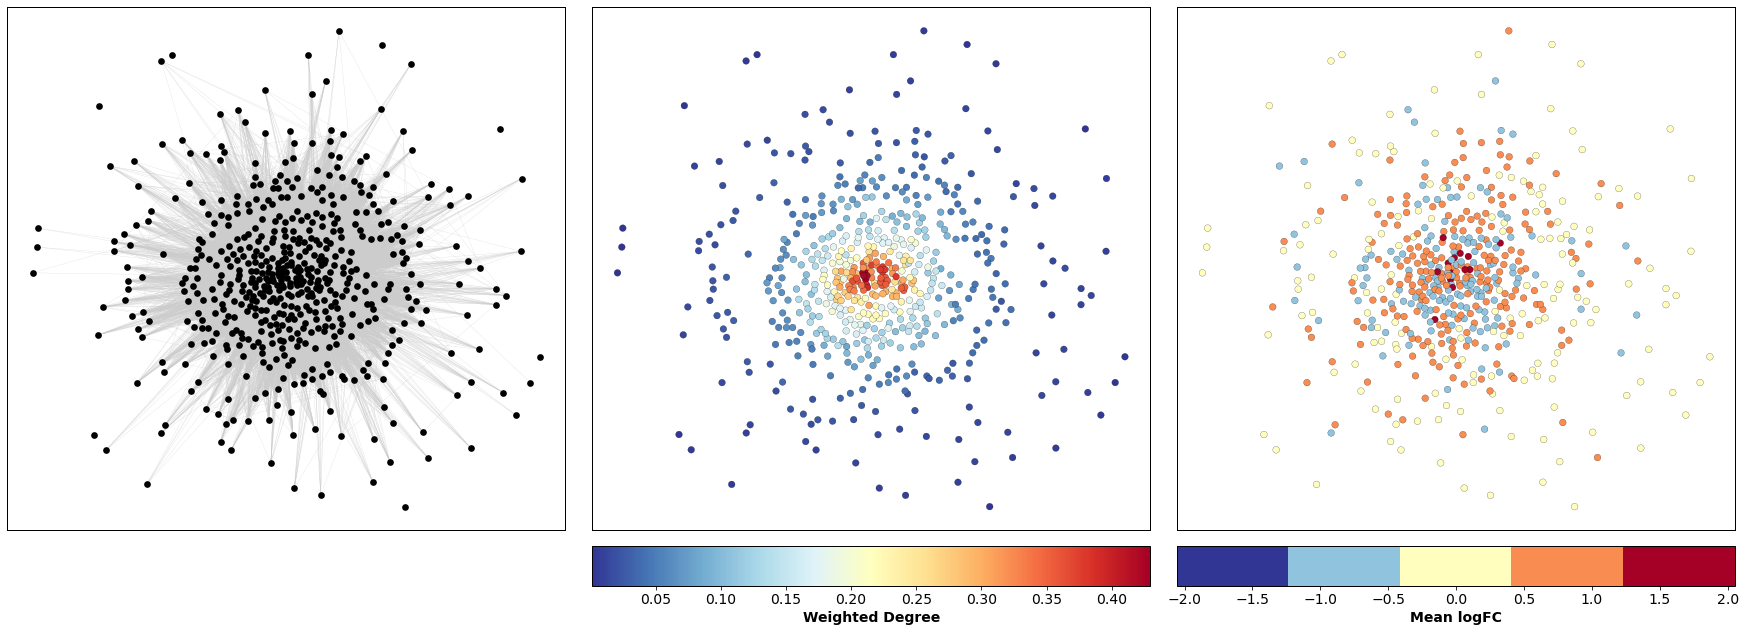

In [55]:
#get the EDGE WEIGHTS for edges in the network that pass the edge weight threshold
edge_weight_dict_subset = {key:value for key, value in edge_weight_dict.items() if value >= edge_weight_thresh}
edge_weight_array_subset = np.array(list(edge_weight_dict_subset.values()))

#get the SUBGRAPH induced by the most heavily weighted edges
S = G.edge_subgraph(list(edge_weight_dict_subset.keys()))

#print some stats
print(f'Number of Nodes = {len(S.nodes)}')

#visualize subgraph
pos = nx.spring_layout(S , weight = 'weight' , iterations = 350 , k = 3.0) #positions of nodes will be used for this visualization and downstream
visualize_network_color_by_weighted_deg_and_logFC(S, pos, 'network colored by weighted deg and mean logFC nodes with edgweight thresh 0.375')

Run **gene set enrichment** on the nodes in this network

In [56]:
#gene set enrichment
gene_enrichr_df = run_enrichr_on_list_of_genes(list(S.nodes), 'IMMUNE')

#average the (weighted degree) for each gene detected as part of the gene set and append as another column
#weighted degree for nodes in this network
node_list = [node_deg[0] for node_deg in list(S.degree(weight = 'weight'))]
degree_list = [node_deg[1] for node_deg in list(S.degree(weight = 'weight'))]
node_weighted_deg_values = pd.Series(degree_list , index = node_list) / float(len(node_list)) #normalize by # of nodes
avg_weighted_deg = [node_weighted_deg_values[gene_enrichr_df.Genes[pathway_i].split(';')].mean() for pathway_i in gene_enrichr_df.index]
gene_enrichr_df.loc[: , 'weighted_deg'] = avg_weighted_deg

In [58]:
gene_enrichr_df.head(n=30)

,ID,P-value,Adjusted P-value,Overlap,Genes,Title,Category,logFC,weighted_deg
0,LI.M37.0,1.303928e-52,1.929813e-50,83/347,SH2D1A;DEFA1;S100A8;AQP9;SMCO4;PYGL;CLEC5A;DEF...,immune activation - generic cluster,immune,0.442557,0.126334
1,LI.M7.0,1.129584e-39,8.358925e-38,36/62,RASGRP1;SH2D1A;GZMK;PRKCQ;ITM2A;CD3G;BCL11B;UB...,enriched in T cells (I),immune,-0.583780,0.210614
2,LI.M7.1,3.798855e-32,1.874102e-30,29/50,RASGRP1;CD3G;BCL11B;THEMIS;CD3D;EOMES;CD27;CD2...,T cell activation (I),immune,-0.560203,0.194925
3,LI.M11.0,1.473634e-27,5.452445e-26,44/189,AQP9;S100A8;PYGL;HSPA6;TIMP2;TLR8;LMO2;CRISPLD...,enriched in monocytes (II),immune,0.607733,0.127398
4,LI.M7.4,8.051571e-19,2.383265e-17,13/15,RASGRP1;RORA;ETS1;LEF1;ZMYND11;KLF12;NELL2;CD9...,T cell activation (III),immune,-0.589158,0.195606
5,LI.M5.0,3.173815e-18,7.828743e-17,24/81,CD3G;UBASH3A;THEMIS;PLCG1;CD3D;FCGR1B;LIME1;CD...,regulation of antigen presentation and immune ...,immune,-0.068810,0.157785
6,LI.M7.2,1.382207e-14,2.922380e-13,17/49,TGFBR3;ZAP70;ITK;KLRB1;RORA;GNLY;STAT4;IL2RB;K...,enriched in NK cells (I),immune,-0.498587,0.215449
7,LI.M7.3,3.839892e-14,7.103800e-13,14/31,SLAMF1;LCK;ITK;ZAP70;ICOS;IL18R1;CD3G;CD3E;STA...,T cell activation (II),immune,-0.446290,0.146124
8,LI.M4.0,1.172458e-13,1.928042e-12,39/335,HSPA6;TIMP2;TLR8;LMO2;CYP1B1;LILRA6;LMNB1;CD36...,cell cycle and transcription,biological process,0.614675,0.120186
9,LI.M75,1.426366e-13,2.111021e-12,12/22,IFIH1;C1QB;OAS1;DDX60;SERPING1;HERC5;FCER1A;IR...,antiviral IFN signature,immune,0.751009,0.149283


In [59]:
gene_enrichr_df.tail(n=33)

,ID,P-value,Adjusted P-value,Overlap,Genes,Title,Category,logFC,weighted_deg
30,LI.M112.0,2.382798e-07,0.000001,7/17,C1QB;C1QC;SERPING1;C3AR1;C2;C1QA;CR1,complement activation (I),immune,1.030360,0.125391
31,LI.M157,1.363997e-06,0.000006,6/14,RASGRP1;MATK;CD7;PPP1R16B;PVRIG;GPR18,enriched in NK cells (III),immune,-0.615567,0.132185
32,LI.M61.0,3.558192e-06,0.000016,7/24,TGFBR3;KLRB1;CD7;IL2RB;CD247;CD96;PVRIG,enriched in NK cells (II),immune,-0.589111,0.229666
33,LI.M25,4.334750e-06,0.000018,5/10,ASGR1;TLR8;ASGR2;BCL6;TNFSF13B,TLR8-BAFF network,immune,0.561006,0.126665
34,LI.M113,4.334750e-06,0.000018,5/10,FAM198B;LPCAT2;TLR8;B3GNT5;SORT1,golgi membrane (I),location,0.516361,0.073677
35,LI.M44,4.334750e-06,0.000018,5/10,IL23A;MAPK14;LCK;IL7R;IFI30,T cell signaling and costimulation,immune,-0.155002,0.157094
36,LI.M111.1,7.758757e-06,0.000031,5/11,CASP1;ZBP1;TAP1;TNFSF13B;IFIT2,viral sensing & immunity; IRF2 targets network...,immune,0.473618,0.190146
37,LI.M69,1.519112e-05,0.000059,6/20,CD79B;FCRL2;FCRL1;CXCR5;CD79A;CD19,enriched in B cells (VI),immune,-0.525913,0.125665
38,LI.S7,2.060265e-05,0.000076,5/13,ITM2A;CD3G;MAL;SLC4A7;CD28,CD4 T cell surface signature Th2-stimulated,immune,-0.463047,0.100547
39,LI.M40,2.060265e-05,0.000076,5/13,C1QB;C1QC;TLR8;LY96;C1QA,complement and other receptors in DCs,immune,0.995304,0.129790


In [60]:
np.shape(gene_enrichr_df)

(63, 9)

#### Organize gene sets into bigger buckets

We're going to manually organize the gene sets above into broader gene set classifications

- **Interferon Type I**: LI.M127

- **Interferon Type II**: LI.M68 - LI.M150 - LI.M111.1 - LI.M111.0 - LI.M75

- **T-cell Response**: LI.M7.0 - LI.M7.1 - LI.M7.4 - LI.M7.3 - LI.M14 - LI.S0 - LI.M19 - LI.M5.1 - LI.M18 - LI.M223 - LI.M44 - LI.S7 - LI.M62.0 - LI.M65 - LI.M36 - LI.M57 - LI.M52

- **Toll-like Receptor**: LI.M16 - LI.M25

- **Antigen Presentation**: LI.M5.0 - LI.M28

- **Dendritic Cells**: LI.M67 - LI.M165 - LI.M40 - LI.M64 - LI.M168

- **Monoctyes**: LI.M11.0 - LI.S4 - LI.M118.0 - LI.M81 - LI.M64

- **Myeloid Cells**: LI.M4.3 - LI.M81

- **B Cells**: LI.M47.0 - LI.M69 - LI.M62.0 - LI.M47.1 - LI.M156.0 - LI.M57

- **Complement**: LI.M112.0 - LI.M40 - LI.M140

- **Natural Killer Cells**: LI.M7.2 - LI.M61.2 - LI.M157 - LI.M61.0

- **Neutrophils**: LI.M37.1

In [61]:
gene_set_group_dict = {
    'Interferon Type I': ['LI.M127'],
    'Interferon Type II': ['LI.M68','LI.M150','LI.M111.1','LI.M111.0','LI.M75'],
    'T-cell Response': ['LI.M7.0','LI.M7.1','LI.M7.4','LI.M7.3','LI.M14','LI.S0','LI.M19','LI.M5.1','LI.M18','LI.M223','LI.M44','LI.S7','LI.M62.0','LI.M65','LI.M36','LI.M57','LI.M52'],
    'Toll-like Receptor': ['LI.M16','LI.M25'],
    'Antigen Presentation': ['LI.M5.0','LI.M28'],
    'Dendritic Cells': ['LI.M67','LI.M165','LI.M40','LI.M64','LI.M168'],
    'Monoctyes': ['LI.M11.0','LI.S4','LI.M118.0','LI.M81','LI.M64'],
    'Myeloid Cells': ['LI.M4.3','LI.M81'],
    'B Cells': ['LI.M47.0','LI.M69','LI.M62.0','LI.M47.1','LI.M156.0','LI.M57'],
    'Complement': ['LI.M112.0','LI.M40','LI.M140'],
    'Natural Killer Cells': ['LI.M7.2','LI.M61.2','LI.M157','LI.M61.0'],
    'Neutrophils': ['LI.M37.1']
    }

Add **column** to gene enriched df to indicate gene group assignment

In [62]:
gene_set_list_for_df = []
#iterate through each enriched pathway and find corresponding gene group assignment
for gene_pathway_id in gene_enrichr_df.ID:
    gene_group_assignment = ''
    for gene_group in gene_set_group_dict.keys():
        if gene_pathway_id in gene_set_group_dict[gene_group]:
            if gene_group_assignment == '':
                gene_group_assignment = gene_group
            else:
                gene_group_assignment = gene_group_assignment + '/' + gene_group
    gene_set_list_for_df.append(gene_group_assignment)
    
gene_enrichr_df.loc[:  , 'Gene Group'] = gene_set_list_for_df 

In [64]:
gene_enrichr_df.head(n=30)

,ID,P-value,Adjusted P-value,Overlap,Genes,Title,Category,logFC,weighted_deg,Gene Group
0,LI.M37.0,1.303928e-52,1.929813e-50,83/347,SH2D1A;DEFA1;S100A8;AQP9;SMCO4;PYGL;CLEC5A;DEF...,immune activation - generic cluster,immune,0.442557,0.126334,
1,LI.M7.0,1.129584e-39,8.358925e-38,36/62,RASGRP1;SH2D1A;GZMK;PRKCQ;ITM2A;CD3G;BCL11B;UB...,enriched in T cells (I),immune,-0.583780,0.210614,T-cell Response
2,LI.M7.1,3.798855e-32,1.874102e-30,29/50,RASGRP1;CD3G;BCL11B;THEMIS;CD3D;EOMES;CD27;CD2...,T cell activation (I),immune,-0.560203,0.194925,T-cell Response
3,LI.M11.0,1.473634e-27,5.452445e-26,44/189,AQP9;S100A8;PYGL;HSPA6;TIMP2;TLR8;LMO2;CRISPLD...,enriched in monocytes (II),immune,0.607733,0.127398,Monoctyes
4,LI.M7.4,8.051571e-19,2.383265e-17,13/15,RASGRP1;RORA;ETS1;LEF1;ZMYND11;KLF12;NELL2;CD9...,T cell activation (III),immune,-0.589158,0.195606,T-cell Response
5,LI.M5.0,3.173815e-18,7.828743e-17,24/81,CD3G;UBASH3A;THEMIS;PLCG1;CD3D;FCGR1B;LIME1;CD...,regulation of antigen presentation and immune ...,immune,-0.068810,0.157785,Antigen Presentation
6,LI.M7.2,1.382207e-14,2.922380e-13,17/49,TGFBR3;ZAP70;ITK;KLRB1;RORA;GNLY;STAT4;IL2RB;K...,enriched in NK cells (I),immune,-0.498587,0.215449,Natural Killer Cells
7,LI.M7.3,3.839892e-14,7.103800e-13,14/31,SLAMF1;LCK;ITK;ZAP70;ICOS;IL18R1;CD3G;CD3E;STA...,T cell activation (II),immune,-0.446290,0.146124,T-cell Response
8,LI.M4.0,1.172458e-13,1.928042e-12,39/335,HSPA6;TIMP2;TLR8;LMO2;CYP1B1;LILRA6;LMNB1;CD36...,cell cycle and transcription,biological process,0.614675,0.120186,
9,LI.M75,1.426366e-13,2.111021e-12,12/22,IFIH1;C1QB;OAS1;DDX60;SERPING1;HERC5;FCER1A;IR...,antiviral IFN signature,immune,0.751009,0.149283,Interferon Type II


In [65]:
gene_enrichr_df.tail(n=33)

,ID,P-value,Adjusted P-value,Overlap,Genes,Title,Category,logFC,weighted_deg,Gene Group
30,LI.M112.0,2.382798e-07,0.000001,7/17,C1QB;C1QC;SERPING1;C3AR1;C2;C1QA;CR1,complement activation (I),immune,1.030360,0.125391,Complement
31,LI.M157,1.363997e-06,0.000006,6/14,RASGRP1;MATK;CD7;PPP1R16B;PVRIG;GPR18,enriched in NK cells (III),immune,-0.615567,0.132185,Natural Killer Cells
32,LI.M61.0,3.558192e-06,0.000016,7/24,TGFBR3;KLRB1;CD7;IL2RB;CD247;CD96;PVRIG,enriched in NK cells (II),immune,-0.589111,0.229666,Natural Killer Cells
33,LI.M25,4.334750e-06,0.000018,5/10,ASGR1;TLR8;ASGR2;BCL6;TNFSF13B,TLR8-BAFF network,immune,0.561006,0.126665,Toll-like Receptor
34,LI.M113,4.334750e-06,0.000018,5/10,FAM198B;LPCAT2;TLR8;B3GNT5;SORT1,golgi membrane (I),location,0.516361,0.073677,
35,LI.M44,4.334750e-06,0.000018,5/10,IL23A;MAPK14;LCK;IL7R;IFI30,T cell signaling and costimulation,immune,-0.155002,0.157094,T-cell Response
36,LI.M111.1,7.758757e-06,0.000031,5/11,CASP1;ZBP1;TAP1;TNFSF13B;IFIT2,viral sensing & immunity; IRF2 targets network...,immune,0.473618,0.190146,Interferon Type II
37,LI.M69,1.519112e-05,0.000059,6/20,CD79B;FCRL2;FCRL1;CXCR5;CD79A;CD19,enriched in B cells (VI),immune,-0.525913,0.125665,B Cells
38,LI.S7,2.060265e-05,0.000076,5/13,ITM2A;CD3G;MAL;SLC4A7;CD28,CD4 T cell surface signature Th2-stimulated,immune,-0.463047,0.100547,T-cell Response
39,LI.M40,2.060265e-05,0.000076,5/13,C1QB;C1QC;TLR8;LY96;C1QA,complement and other receptors in DCs,immune,0.995304,0.129790,Dendritic Cells/Complement


### *Function* to visualize a color a specific list of nodes

In [66]:
def visualize_network_color_by_inclusion_in_node_set(G, ax, pos, node_set, color, pathway_name, num_nodes):
    
    #color nodes by whether they belong in gene set (given color) or not (grey)
    node_color_dict = {True:color, False:'0.85'}
    node_colors = [node_color_dict[node_i in node_set] for node_i in G.nodes]
    
    #nodes in node set
    H = G.subgraph(node_set)
    collection = nx.draw_networkx_nodes(
        H, 
        pos = pos, 
        ax = ax,
        node_size = 25, 
        node_color = color,
        linewidths = 0.25,
        edge_color = "0.83",
        width=0.0,
        alpha = 1.0, 
        with_labels = False)
    collection.set_zorder(2)
    ax.collections[0].set_edgecolor("black") #color of the node outlines
    
    #nodes not in node set
    H = G.subgraph([node_i for node_i in G.nodes if node_i not in node_set])
    collection = nx.draw_networkx_nodes(
        H, 
        pos = pos, 
        ax = ax,
        node_size = 20, 
        node_color = '0.85',
        linewidths = 0.0,
        edge_color = "0.83",
        width=0.0,
        alpha = 0.8, 
        with_labels = False)
    collection.set_zorder(1)
    
    #average the (weighted degree) for each gene detected as part of the gene set
    avg_weighted_deg = round(node_weighted_deg_values[genes_in_category_i].mean(), 2)
    
    #average the (mean logFC) for each gene detected as part of the gene set
    avg_meanlogFC = round(mean_logFC_series[genes_in_category_i].mean(), 2)
    
    ax.set_title(f'{pathway_name}\nN={num_nodes} / avg weight deg={avg_weighted_deg} / avg logFC={avg_meanlogFC}', color = 'k', fontsize = 11)

Assign a color to each gene category by pulling from a color map

In [67]:
num_gene_categories = len(gene_set_group_dict.keys()) #number of gene categories (subplots)
color_scheme = discrete_cmap(num_gene_categories, 'jet') #pull a color map and discretize it
norm = mpl.colors.Normalize(vmin = 0, vmax = num_gene_categories) #get the normalization
color_scheme_norm = mpl.cm.ScalarMappable(norm = norm, cmap = color_scheme) #normalize the color map to the min/max values of the node values

#get color for each node from color map
gene_category_color_dict = {}
i = 0
for gene_category_i in gene_set_group_dict.keys(): #iterate through gene categories
    gene_category_color_dict[gene_category_i] = 'k' # color_scheme_norm.to_rgba(i)
    i += 1

In [68]:
print(f'Number of Gene Groups = {len(gene_category_color_dict.keys())}')

Number of Gene Groups = 12


#### Visualize nodes that belong to the enriched gene categories

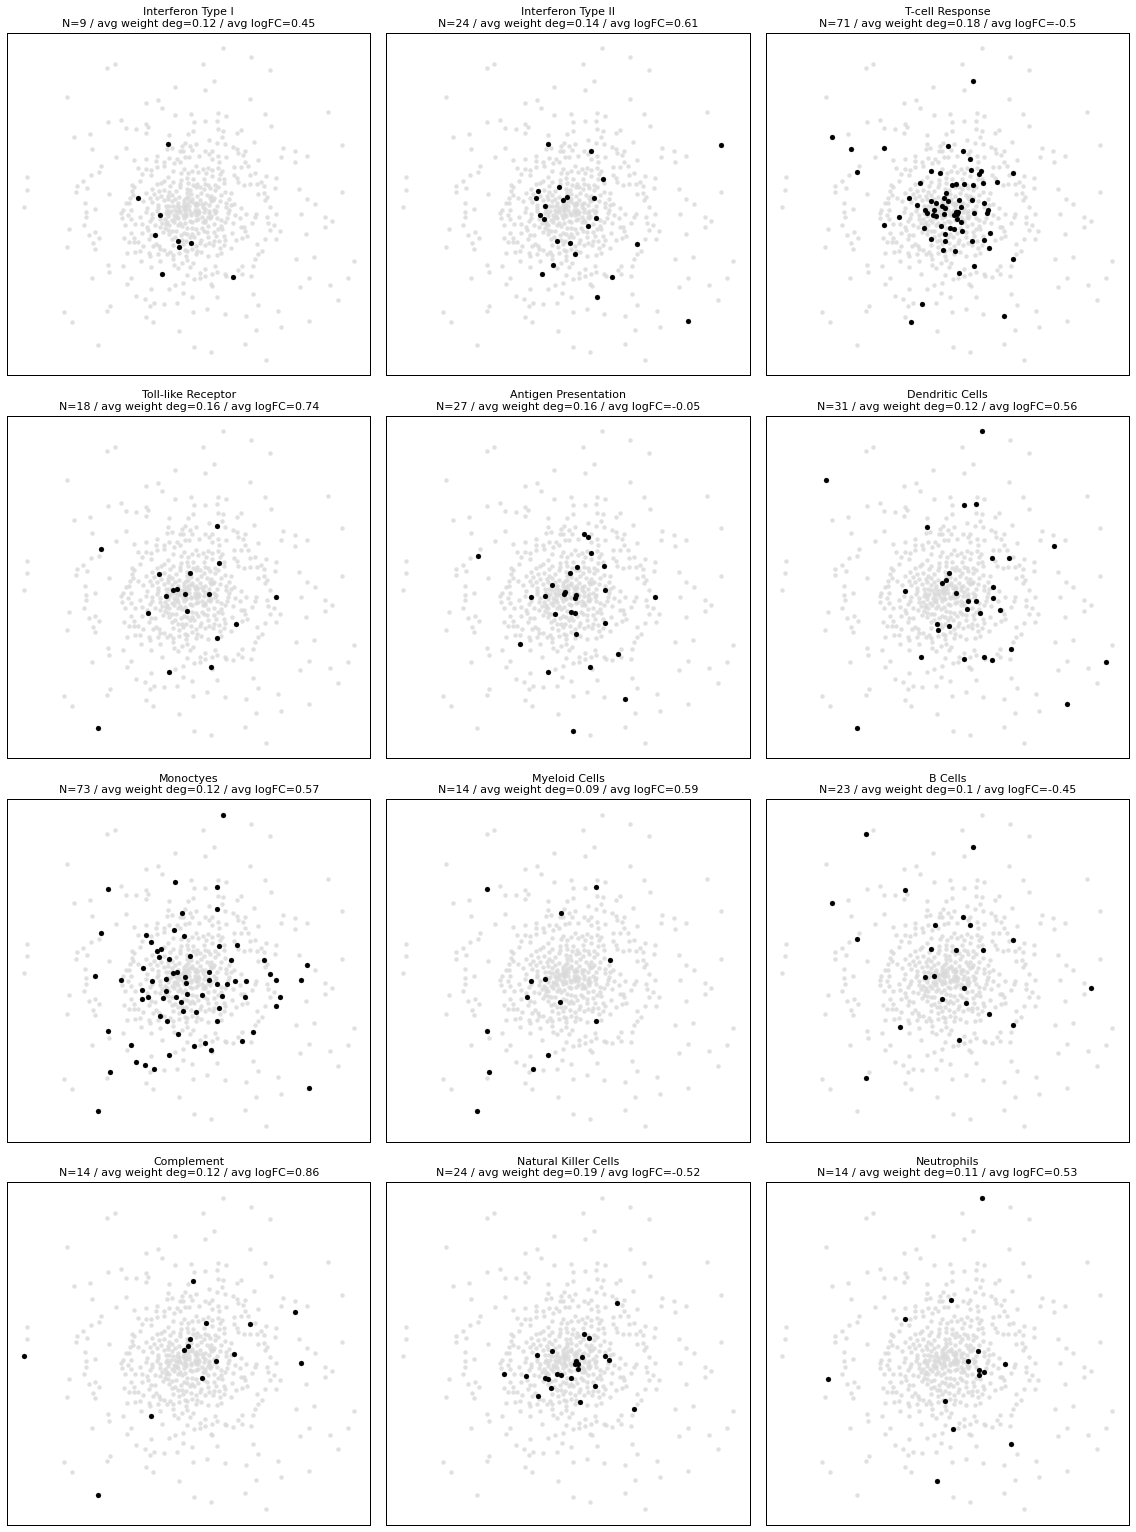

In [69]:
fig = plt.figure(constrained_layout=True)

gs = GridSpec(4, 3, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1])
ax6 = fig.add_subplot(gs[1, 2])
ax7 = fig.add_subplot(gs[2, 0])
ax8 = fig.add_subplot(gs[2, 1])
ax9 = fig.add_subplot(gs[2, 2])
ax10 = fig.add_subplot(gs[3, 0])
ax11 = fig.add_subplot(gs[3, 1])
ax12 = fig.add_subplot(gs[3, 2])

#iterate through each gene category & axis
for gene_category_i, ax in zip(gene_set_group_dict.keys(), [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12]):
    
    #get all the genes that belongs to the enriched pathways for this gene category
    genes_in_category_i = []
    
    #iterate through each pathway tied to this gene category
    for enriched_pathway_i in gene_set_group_dict[gene_category_i]:

        genes_in_enriched_pathway_i = gene_enrichr_df[gene_enrichr_df.ID == enriched_pathway_i].Genes.values[0]
        genes_in_enriched_pathway_i = genes_in_enriched_pathway_i.split(';')
        genes_in_category_i = genes_in_category_i + genes_in_enriched_pathway_i

    genes_in_category_i = list(set(genes_in_category_i)) #get rid of repeat genes
    gene_category_color = gene_category_color_dict[gene_category_i] #get the color assigned to this gene category
    num_nodes_category_i = str(len(genes_in_category_i)) #number of nodes

    visualize_network_color_by_inclusion_in_node_set(S, ax, pos, genes_in_category_i, gene_category_color, gene_category_i, num_nodes_category_i)

################### Plot
fig = plt.gcf()
fig.set_size_inches(16.0, 21.5)
fig.tight_layout()

file_name = f'{figures_dir_path}/{comparison_X} network with nodes colored according to functional immune gene groups.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()